In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg, scipy.integrate
import do
from importlib import reload
from IPython.display import display, clear_output
from quantum_systems import ODQD, GeneralOrbitalSystem

In [19]:
### PARAMETERS ###
l = 20 # Number of eigenstates of the HO potential --> we use these functions to generate the single particle WF
grid_length = 10  # The width of the one-dimensional grid
num_grid_points = 201  # The number of discretized points on the grid.
# More points give better results for the single-particle basis at the cost of slower setup.
alpha = 1  # The strength of the Coulomb interaction 
a = 0.25  # The shielding parameter in the Coulomb interaction potential
Omega = 0.25  # The frequency of the harmonic oscillator trap
omega = 8*Omega # frequency of the laser field
epsilon0 = 1.0 # amplitude of the laser field
potential=ODQD.HOPotential(Omega)
nparticles = 2

In [20]:
reload(do)
odho = ODQD(l, grid_length, num_grid_points, a=a, alpha=alpha, potential=potential)
system = GeneralOrbitalSystem(n=nparticles, basis_set=odho, anti_symmetrize=True)
epsilon, C0 = do.solve_TIHF(system, nparticles, tolerance=1e-7, max_iter=1000, print_on=False)
#system.change_basis(C0)
#print(system.compute_reference_energy())

In [21]:
import time
reload(do)
odho = ODQD(l, grid_length, num_grid_points, a=a, alpha=alpha, potential=potential)
system = GeneralOrbitalSystem(n=nparticles, basis_set=odho, anti_symmetrize=True)
epsilon, C0 = do.solve_TIHF(system, nparticles, tolerance=1e-7, max_iter=1000, print_on=False)
#t1 = time.time()
#do.change_basis(system, C0)
#t2 = time.time()
#print(t2-t1)
print(system.compute_reference_energy())

(1.3837416136235365+0j)


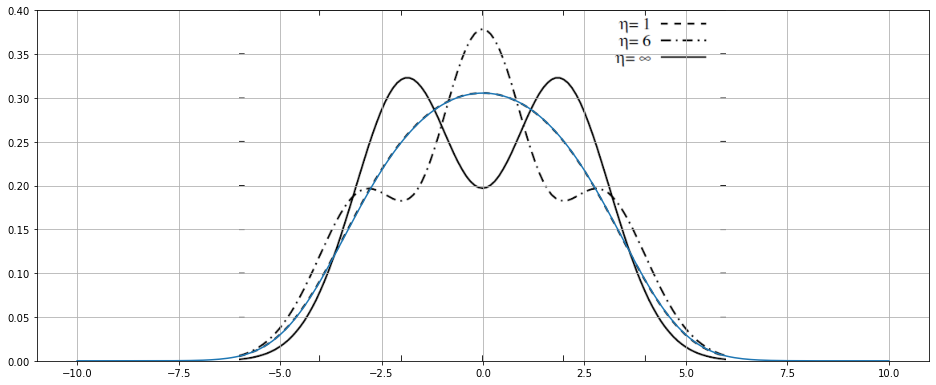

In [22]:
reload(do)
obd = do.eval_one_body_density(system, nparticles, C0)
do.plot_overlap_one_body_density(system, obd)

0 0.001


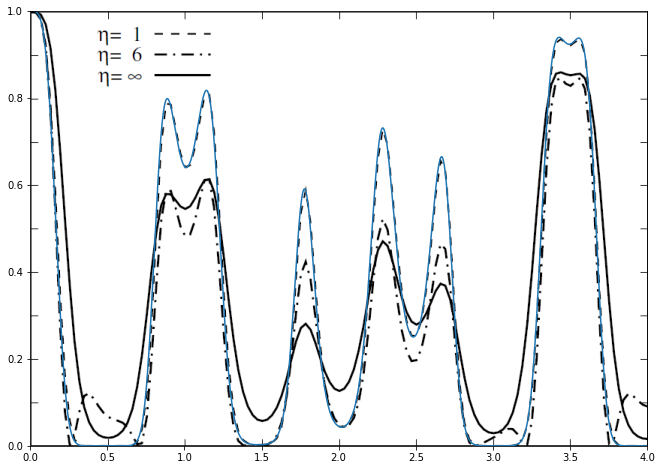

In [24]:
reload(do)
dt = 1e-3
t_max = 4*2*np.pi/omega
rhs = do.wrapfunc(do.rhsf, args=[system, omega, epsilon0, nparticles])
integrator = scipy.integrate.ode(rhs.f).set_integrator('zvode')
integrator.set_initial_value( np.reshape(C0, len(C0)**2 ), 0)
overlap,time = do.solve_TDHF(system, dt, t_max, C0, omega, epsilon0, nparticles, integrator, animation=False)
do.plot_overlap_slater_det(system, overlap, time)

In [ ]:
# Matteo's version of the plotting
reload(do)
dt=1e-2
import matplotlib.animation as animation
fig, ax = plt.subplots()
x = np.linspace(0, 2*np.pi, 1000)
line, = ax.plot(system.grid, do.eval_one_body_density(system, nparticles, C0).real)
integrator = scipy.integrate.ode(rhs.f).set_integrator('zvode')
integrator.set_initial_value( np.reshape(C0, len(C0)**2 ), 0)
ani = animation.FuncAnimation(fig, do.animation, fargs=(line, system, dt, t_max, C0, omega, epsilon0, nparticles, integrator), interval=200, blit=True, save_count=1000)
from IPython.display import HTML
HTML(ani.to_jshtml())

In [112]:
a1 = np.array([[1,2,3,4],[10,11,12,13],[20,21,22,23]])
a2 = np.array([1,2,3])
a3 = a1.T*a2
print(a3.T)
np.sum(a3.T,axis=0)

[[ 1  2  3  4]
 [20 22 24 26]
 [60 63 66 69]]


array([81, 87, 93, 99])

In [14]:
reload(do)
do.change_basis(system, C0, nparticles)
do.plot_MO_abc(system,potential,epsilon)

TypeError: change_basis() takes 2 positional arguments but 3 were given